#### Import Required Libraries

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#### Load the MNIST Dataset

In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit DenseNet's input size
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the dataset
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#### Split the Dataset

In [32]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, _ = random_split(dataset, [train_size, val_size, test_size])

#### Load Data into Dataloaders

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


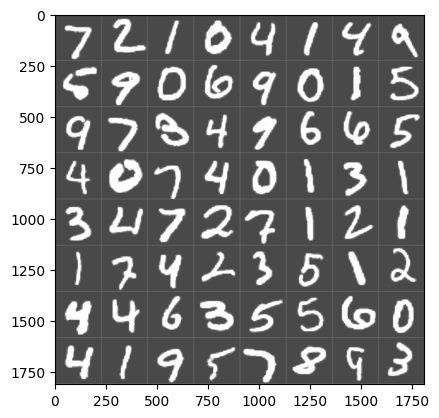

Labels: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [37]:
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random training images
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', labels)

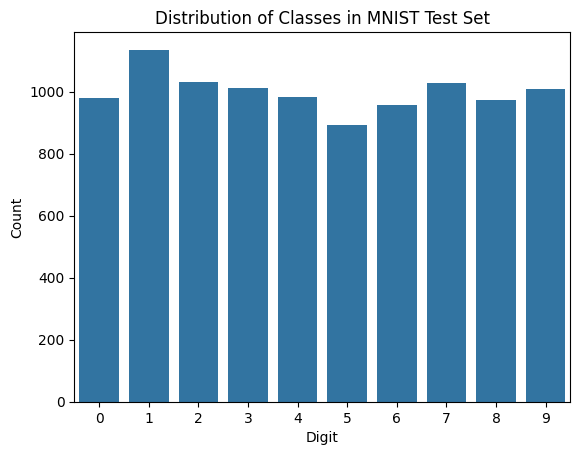

In [40]:
import seaborn as sns

# Plotting class distribution
classes = [label for _, label in test_loader.dataset]
sns.countplot(x=classes)
plt.title('Distribution of Classes in MNIST Test Set')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

#### Load Pre-trained DenseNet

In [9]:
model = models.densenet121(pretrained=True)

num_features = model.classifier.in_features
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.classifier = nn.Linear(num_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#### Loss Function and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Your device has a GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Your device is using the CPU.")


CUDA is available. Your device has a GPU.
Device name: NVIDIA GeForce RTX 4070 Laptop GPU


#### Train the Model

In [18]:
def train(model, device, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}', flush=True)

    return train_losses, val_losses

train_losses, val_losses = train(model, device, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1, Training Loss: 0.0236, Validation Loss: 0.0396
Epoch 2, Training Loss: 0.0214, Validation Loss: 0.0366
Epoch 3, Training Loss: 0.0181, Validation Loss: 0.0331
Epoch 4, Training Loss: 0.0167, Validation Loss: 0.0327
Epoch 5, Training Loss: 0.0181, Validation Loss: 0.0308
Epoch 6, Training Loss: 0.0109, Validation Loss: 0.0296
Epoch 7, Training Loss: 0.0154, Validation Loss: 0.0519
Epoch 8, Training Loss: 0.0130, Validation Loss: 0.0383
Epoch 9, Training Loss: 0.0085, Validation Loss: 0.0399
Epoch 10, Training Loss: 0.0124, Validation Loss: 0.0333


In [19]:
model_path = "densenet_mnist.pth"
torch.save(model.state_dict(), model_path)
print("Model saved!")

Model saved!


In [20]:
import os

model_path = "densenet_mnist.pth"
# model = models.densenet121(pretrained=True)
# num_features = model.classifier.in_features
# model.classifier = nn.Linear(num_features, 10)
# model = model.to(device)

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from disk, skipping training.")
# else:
#     # If the model doesn't exist, train and save it
#     train_losses, val_losses = train(model, device, train_loader, val_loader, criterion, optimizer, epochs=10)
#     torch.save(model.state_dict(), model_path)
#     print("Model trained and saved!")

Model loaded from disk, skipping training.


/tmp/ipykernel_3828/2266461651.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


#### Training and Validation Loss

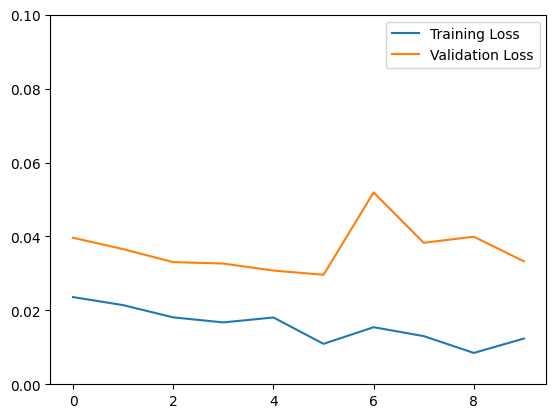

In [26]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

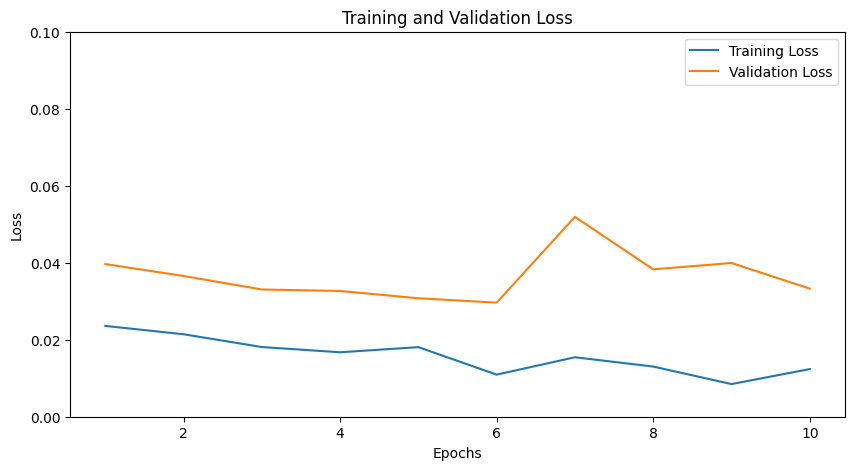

In [43]:
epochs = range(1, 11)  # Adjust based on the number of epochs

# Plot training and validation losses
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.1)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


#### Evaluate the Model on the Test Set

In [22]:
def evaluate(model, device, test_loader):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(target.cpu().numpy())

    return accuracy_score(test_labels, test_preds)

test_accuracy = evaluate(model, device, test_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 99.29%


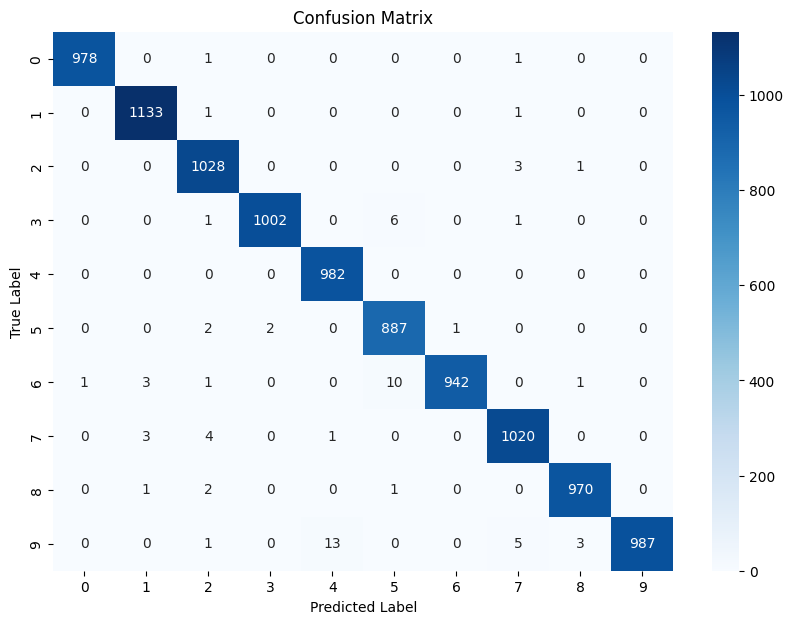

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions and true labels
all_preds = torch.tensor([])
all_labels = torch.tensor([])

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, predicted.cpu()), dim=0)
        all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()